# 🧠 Building `makemore` Part 3: Activations, Gradients, BatchNorm

> **Tutorial Series:** Neural Networks: Zero to Hero  
> **Video Link:** [Building makemore Part 3](https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4)  
> **Focus Areas:** Understanding activations, gradients, and batch normalization in neural networks

## 📋 Overview
This notebook covers advanced concepts in building neural networks, specifically focusing on:
- **Activations**: How neurons fire and pass information
- **Gradients**: How the network learns through backpropagation  
- **Batch Normalization**: Stabilizing training and improving performance

### 🎯 Starting Point
**Video Timestamp:** [1:23 - Setting up the foundation](https://youtu.be/P6sfmUTpUmc?si=NaDZmPDVSSVEshtF&t=83)

## 📦 Imports and Setup
Setting up our development environment with essential libraries for neural network implementation.

In [92]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [93]:
words = open('names.txt', 'r').read().splitlines()
print(words[:8])
print("Number of Words: ", len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
Number of Words:  32033


## 🔤 Character Vocabulary Setup
Creating the character-to-integer mappings that will serve as our model's vocabulary.

**Components:**
- `chars`: Sorted list of unique characters from our dataset
- `stoi`: String-to-integer mapping (encoding)  
- `itos`: Integer-to-string mapping (decoding)
- Special `.` token for start/end of sequences

In [94]:
# character list
chars = sorted(list(set(''.join(words))))
chars.insert(0, '.') # special starter/terminator character

# string to integer
stoi = {s: i for i, s in enumerate(chars)}

# integer to string
itos = {i: s for s, i in stoi.items()}

## 🏗️ Dataset Building Function
Creating training examples from our name dataset using a sliding window approach.

**Function Logic:**
1. **Context Window**: Uses `block_size` previous characters to predict the next
2. **Sliding Window**: Moves through each name character by character
3. **Tensor Conversion**: Converts lists to PyTorch tensors for training

**Parameters:**
- `words`: List of names to process
- `block_size`: Size of context window (default: 3 characters)

In [95]:
block_size = 3

def build_dataset(words):

    X, Y = [], []

    for w in words:
        context = [0] * block_size

        for ch in w + '.':
            
            X.append(context)
            ix = stoi[ch]
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

In [96]:
sampleX, sampleY = build_dataset('mariana') # sample with 'james'

for x, y in zip(sampleX, sampleY):
    print(f"[{itos[x[0].item()]}, {itos[x[1].item()]}, {itos[x[2].item()]}] ⇨ [{itos[y.item()]}]")
    print(f"{x.tolist()} ⇨ [{y.item()}]\n")

[., ., .] ⇨ [m]
[0, 0, 0] ⇨ [13]

[., ., m] ⇨ [.]
[0, 0, 13] ⇨ [0]

[., ., .] ⇨ [a]
[0, 0, 0] ⇨ [1]

[., ., a] ⇨ [.]
[0, 0, 1] ⇨ [0]

[., ., .] ⇨ [r]
[0, 0, 0] ⇨ [18]

[., ., r] ⇨ [.]
[0, 0, 18] ⇨ [0]

[., ., .] ⇨ [i]
[0, 0, 0] ⇨ [9]

[., ., i] ⇨ [.]
[0, 0, 9] ⇨ [0]

[., ., .] ⇨ [a]
[0, 0, 0] ⇨ [1]

[., ., a] ⇨ [.]
[0, 0, 1] ⇨ [0]

[., ., .] ⇨ [n]
[0, 0, 0] ⇨ [14]

[., ., n] ⇨ [.]
[0, 0, 14] ⇨ [0]

[., ., .] ⇨ [a]
[0, 0, 0] ⇨ [1]

[., ., a] ⇨ [.]
[0, 0, 1] ⇨ [0]



## 📊 Train/Validation/Test Split
Dividing our dataset into three parts for proper machine learning workflow.

**Split Configuration:**
- 🏋️ **Training Set**: 80% of data - Used to train the model
- 🔍 **Development Set**: 10% of data - Used for hyperparameter tuning  
- 🧪 **Test Set**: 10% of data - Final evaluation of model performance

> **Note:** We shuffle the dataset first to ensure random distribution across splits.

In [97]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtr, Ytr    = build_dataset(words[:n1])         # Training Set: 80%
Xdev, Ydev  = build_dataset(words[n1:n2])       # Development Set: 10%
Xte, Yte    = build_dataset(words[n2:])         # Testing Set: 10%

In [98]:
print(Xtr.shape, Ytr.shape)
print(Xdev.shape, Ydev.shape)
print(Xte.shape, Yte.shape)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [99]:
# MLP Revisited
vocab_size = len(chars)
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),                   generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),       generator=g)
b1 = torch.randn((n_hidden),                            generator=g)
W2 = torch.randn((n_hidden, vocab_size),                generator=g)
b2 = torch.randn((vocab_size))

parameters = [C, W1, b1, W2, b2]

## 🧠 Neural Network Architecture Setup
Building our Multi-Layer Perceptron (MLP) with embedding layers for character-level language modeling.

**Architecture Components:**
- 🎯 **Embedding Layer**: `C` - Maps characters to dense vector representations
- 🔗 **Hidden Layer**: `W1`, `b1` - First transformation with 200 neurons
- 📊 **Output Layer**: `W2`, `b2` - Final prediction layer mapping to vocabulary

**Hyperparameters:**
- `vocab_size`: Total number of unique characters in our vocabulary
- `n_embd`: Dimensionality of character embeddings (10D)
- `n_hidden`: Number of neurons in hidden layer (200)
- `block_size`: Context window size (3 characters)

In [100]:
# set parameters for back propagation
for p in parameters:
    p.requires_grad = True

## ⚙️ Parameter Configuration
Enabling gradient computation for all model parameters to allow backpropagation.

In [101]:
# get sum of parameters
print("Total Parameters: ", sum(p.nelement()for p in parameters))

Total Parameters:  11897


### 📈 Model Size Analysis
Calculating the total number of trainable parameters in our neural network.

In [102]:
# training the neural net
max_steps = 200000 # number training epochs
batch_size = 32 # number of samples processed per training epoch
lossi = []

n_total_samples = Xtr.shape[0]

for i in range(max_steps):

    # random sampling from dataset
    ix = torch.randint(0, n_total_samples, (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output later
    loss = F.cross_entropy(logits, Yb) # loss function

    # backwards pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    learning_rate = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -learning_rate * p.grad

    # track stats
    if i % 10000 == 0: # print every 10000 steps
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 26.8600
  10000/ 200000: 2.5388
  10000/ 200000: 2.5388
  20000/ 200000: 2.1177
  20000/ 200000: 2.1177
  30000/ 200000: 2.4573
  30000/ 200000: 2.4573
  40000/ 200000: 2.5676
  40000/ 200000: 2.5676
  50000/ 200000: 1.9535
  50000/ 200000: 1.9535
  60000/ 200000: 2.3781
  60000/ 200000: 2.3781
  70000/ 200000: 1.7906
  70000/ 200000: 1.7906
  80000/ 200000: 2.5487
  80000/ 200000: 2.5487
  90000/ 200000: 2.3252
  90000/ 200000: 2.3252
 100000/ 200000: 2.1811
 100000/ 200000: 2.1811
 110000/ 200000: 1.9288
 110000/ 200000: 1.9288
 120000/ 200000: 1.9644
 120000/ 200000: 1.9644
 130000/ 200000: 2.2330
 130000/ 200000: 2.2330
 140000/ 200000: 1.8585
 140000/ 200000: 1.8585
 150000/ 200000: 2.3067
 150000/ 200000: 2.3067
 160000/ 200000: 2.2053
 160000/ 200000: 2.2053
 170000/ 200000: 1.9159
 170000/ 200000: 1.9159
 180000/ 200000: 1.6473
 180000/ 200000: 1.6473
 190000/ 200000: 2.1449
 190000/ 200000: 2.1449


## 🏃‍♂️ Training Loop
Main training process using stochastic gradient descent with mini-batches.

**Training Configuration:**
- 📊 **Max Steps**: 200,000 training iterations
- 🎯 **Batch Size**: 32 samples per mini-batch
- 📉 **Learning Rate**: 0.1 → 0.01 (step decay at 100k iterations)
- 🔄 **Optimization**: SGD with gradient descent

**Forward Pass:**
1. **Embedding**: Convert character indices to vectors
2. **Concatenation**: Flatten context window embeddings  
3. **Hidden Layer**: Apply linear transformation + tanh activation
4. **Output**: Generate logits for next character prediction
5. **Loss**: Cross-entropy between predictions and targets

**Backward Pass:**
1. **Zero Gradients**: Clear previous gradients
2. **Backpropagate**: Compute gradients via automatic differentiation
3. **Update**: Adjust parameters using computed gradients

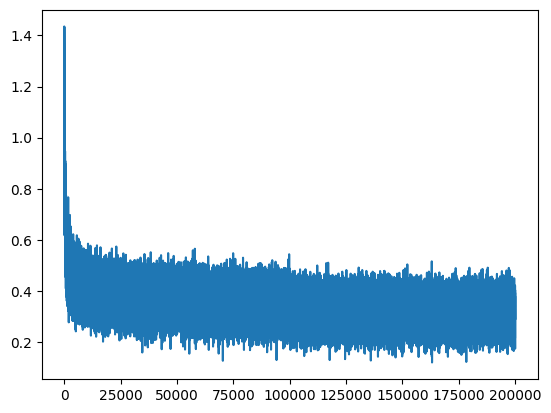

In [103]:
plt.plot(lossi)

### 📊 Training Loss Visualization
Plotting the training loss curve to monitor learning progress over iterations.

In [106]:
# evaluating the model

@torch.no_grad # disable gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1) # )(N, n_hidden)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1221742630004883
val 2.163158416748047


## 🔍 Model Evaluation
Assessing model performance across training, validation, and test sets.

**Evaluation Strategy:**
- 🚫 **No Gradients**: Disable gradient computation for efficiency
- 📊 **Cross-Entropy Loss**: Measure prediction accuracy on each split
- 🎯 **Overfitting Check**: Compare train vs validation performance

> **Key Insight:** If training loss << validation loss, the model is overfitting!

In [110]:
# sampling from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size

    while True:
        # forward pass
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        #sample from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # shift context window
        context = context[1:] + [ix]
        out.append(ix)

        # if we get special . token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carmah.
amille.
khy.
mili.
tatyanna.
sane.
mahnen.
amerynt.
kaeli.
nellara.
chaiir.
kaleigh.
ham.
join.
quinn.
salin.
alianni.
wazelo.
dearixi.
jaxeenivran.


## 🎲 Name Generation
Sampling new names from our trained model using probabilistic generation.

**Generation Process:**
1. **Initialize Context**: Start with empty context window
2. **Forward Pass**: Get probability distribution over next characters
3. **Sample**: Randomly select next character based on probabilities
4. **Update Context**: Shift window and add predicted character
5. **Repeat**: Continue until we generate the end token (`.`)

**Sampling Strategy:**
- 🎯 **Multinomial Sampling**: Probabilistic character selection
- 🔄 **Autoregressive**: Use previous predictions as input for next prediction
- 🛑 **Stop Condition**: Generation ends when model outputs termination token

> **Result:** Creative new names that follow the patterns learned from training data!